In [1]:
import scanpy as sc
import numpy as np
import urllib.request
import anndata
import pandas as pd
from pathlib import Path
from scipy.sparse import issparse
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
font_dirs = ['/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

mpl.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']  
plt.rcParams['pdf.fonttype'] = 42

sns.set_style('white')

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [4]:
df = pd.read_csv('result/scasl/dataset1/20241127195800/normalized_matrix.csv',index_col=0).T
mat = np.load('result/scasl/dataset1/20241127195800/normalized_matrix.npy')

In [6]:
adata = sc.AnnData(mat)
adata.obs_names = df.index

In [8]:
# Read the cell type mapping table and convert it to a dictionary with cell_id as keys and cell_type as values
cell_type_dict = pd.read_table('dataset1/srr_2_cell_type.txt', header=0)
cell_type_dict = cell_type_dict.set_index('cell_id')['cell_type'].to_dict()

# Filter cell IDs in adata that exist in the cell_type_dict keys
cell_ids = [cell_id for cell_id in adata.obs_names if cell_id in cell_type_dict.keys()]

# Subset adata to keep only the filtered cells and create a copy
adata = adata[cell_ids, :].copy()

# Add cell type annotation to adata.obs
adata.obs['cell_type'] = [cell_type_dict[idx] for idx in adata.obs_names]

# Duplicate the 'cell_type' column as 'cell.type' for convenience
adata.obs['cell.type'] = adata.obs['cell_type']

# Replace adata's expression matrix X with the Psi layer (percent spliced-in values)
adata.X = adata.layers['Psi']

In [9]:
def get_predicted_type(adata):
    obs = adata.obs
    type_dict = {}
    for leiden in adata.obs.leiden.cat.categories:
        sub_obs =obs[obs['leiden'] == leiden]
        major_cell_type = sub_obs['cell.type'].value_counts().idxmax()
        type_dict[leiden] = major_cell_type
    adata.obs['AS_cell_type'] = adata.obs['leiden'].astype(str)
    adata.obs['AS_cell_type'] = adata.obs['AS_cell_type'].replace(type_dict)
    return adata
    
def get_accuracy(adata):
    adata = get_predicted_type(adata)
    accuracy = accuracy_score(adata.obs['cell.type'], adata.obs['AS_cell_type'])
    return accuracy

In [10]:
tool = 'SCASL'
results = []

import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score


for n_genes in [2000,5000,'all']:
    if n_genes == 'all':
        ...
    else:
        sc.pp.highly_variable_genes(adata,min_mean=0.0, max_mean=10, min_disp=0.5,n_top_genes=n_genes)

    if n_genes == 'all':
        sc.tl.pca(adata, mask_var=None)
    else:
        sc.tl.pca(adata, mask_var="highly_variable")

    for nei in [10, 15, 20, 30, 40]:
        for pc in [5, 7, 9, 10, 15, 20]:
            sc.pp.neighbors(adata, n_neighbors=nei, n_pcs=pc)
            sc.tl.umap(adata)
            for res in [0.6, 0.7, 0.8, 0.9, 1, 1.1]:
                sc.tl.leiden(adata, resolution=res, random_state=0, n_iterations=10, directed=False)
                
                accuracy = get_accuracy(adata)
                true_labels = adata.obs["cell.type"]
                predicted_labels = adata.obs["AS_cell_type"]
                ari = adjusted_rand_score(true_labels, predicted_labels)
                nmi = normalized_mutual_info_score(true_labels, predicted_labels)
                umap_embedding = adata.obsm["X_umap"]
                silhouette = silhouette_score(umap_embedding, predicted_labels)
                
                # 计算 BCI（四个指标的均值）
                bci = (accuracy + ari + nmi + silhouette) / 4
                
                results.append({
                    'n_top_genes': n_genes,
                    'n_neighbors': nei,
                    'n_pcs': pc,
                    'resolution': res,
                    'accuracy': accuracy,
                    'ARI': ari,
                    'NMI': nmi,
                    'Silhouette': silhouette,
                    'BCI': bci
                })

accuracy_df = pd.DataFrame(results).sort_values(by='BCI', ascending=False)
accuracy_df.to_csv('BCI_{}_.txt'.format(tool),sep='\t')
print(accuracy_df)

/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
2025-07-09 20:50:42.746138: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 20:50:42.748676: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-09 20:50:42.781164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the 



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/tmp/ipykernel_38096/3935599799.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, random_state=0, n_iterations=10, directed=False)
/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    n_top_genes  n_neighbors  n_pcs  resolution  accuracy       ARI       NMI  \
389         all           10     15         1.1  0.929412  0.869641  0.905642   
386         all           10     15         0.8  0.929412  0.869641  0.905642   
387         all           10     15         0.9  0.929412  0.869641  0.905642   
388         all           10     15         1.0  0.929412  0.869641  0.905642   
395         all           10     20         1.1  0.929412  0.870135  0.906665   
..          ...          ...    ...         ...       ...       ...       ...   
147        2000           40      5         0.9  0.637908  0.478513  0.661745   
146        2000           40      5         0.8  0.636601  0.476934  0.661005   
148        2000           40      5         1.0  0.633987  0.476935  0.660840   
108        2000           30      5         0.6  0.586928  0.463007  0.654924   
144        2000           40      5         0.6  0.586928  0.469275  0.657634   

     Silhouette       BCI  

In [ ]:
n_genes,n_neighbors,n_pcs,resolution ,accuracy = accuracy_df.iloc[0]
if n_genes == 'all':
        ...
else:
    sc.pp.highly_variable_genes(adata,min_mean=0.0, max_mean=10, min_disp=0.5,n_top_genes=n_genes)
    
if n_genes == 'all':
    sc.tl.pca(adata, mask_var=None)
else:
    sc.tl.pca(adata, mask_var="highly_variable")
sc.pp.neighbors(adata, n_neighbors=int(n_neighbors), n_pcs=int(n_pcs))
sc.tl.umap(adata,)
sc.tl.leiden( adata, resolution=resolution, random_state=0,n_iterations=10, directed=False,) #聚类跟umap或是tsne都没关系
adata = get_predicted_type(adata)

/home/jiangquanlong/miniconda3/envs/r_env/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
2025-05-12 22:25:38.766734: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 22:25:38.802114: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 22:25:38.991136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 22:25:39.765425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/tmp/ipykernel_21747/2459424056.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden( adata, resolution=resolution, random_state=0,n_iterations=10, directed=False,) #聚类跟umap或是tsne都没关系


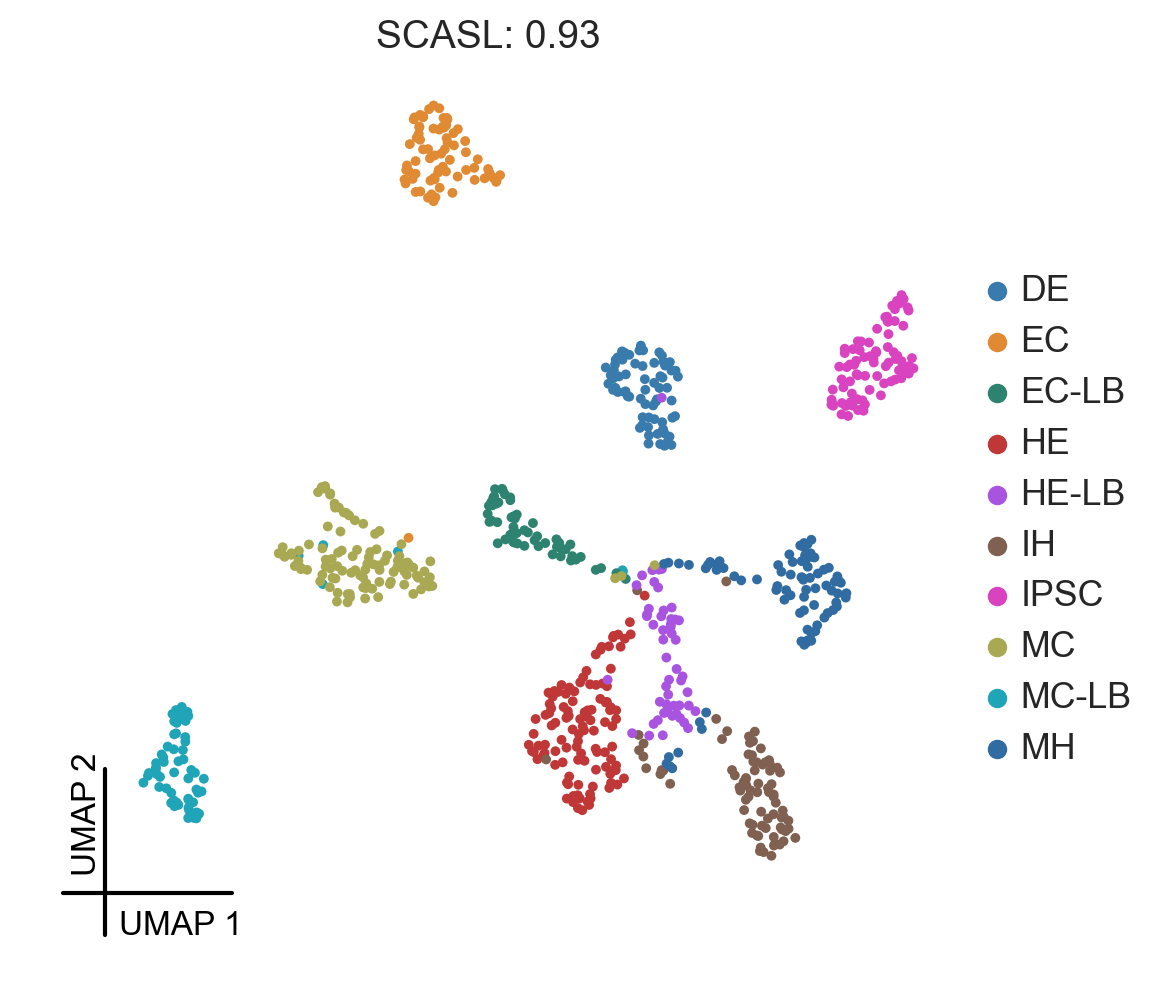

In [12]:
sc.settings.set_figure_params(
    dpi=100,               # 图像分辨率
    facecolor='white'      # 背景颜色
)

tool = 'SCASL'
custom_palette = ['#3a7bae', '#e08b33', '#2d8270', '#c03737', '#a854e1', '#806051',
                  '#d943bf', '#a9a853', '#1fa5b7', '#306ba1', '#ff9c33', '#3daf84',
                  '#de4848', '#b553f0']

title = '{}: {:.2}'.format(tool,accuracy)
fo = "umap_accuracy.{}.pdf".format(tool)

fig, ax = plt.subplots(figsize=(6, 6))
# 绘制 UMAP 图
sc.pl.umap(
    adata,
    color="cell.type",  # 替换为你的分类变量
    palette=custom_palette,
    ax=ax,
    show=False,
    frameon=False, # 关闭默认边框
    s = 50,title=title)

# 获取当前轴范围
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 参数设置
border_length = 0.15  # 边框长度比例
arrow_size = 0.03    # 箭头长度比例
line_width = 1.5     # 线条粗细

# 绘制短边框和箭头
left_border_extension = 0.05  # 左边框向下延伸的比例
bottom_border_extension = 0.05  # 下边框向左延伸的比例

# 绘制短边框和箭头
ax.plot([xlim[0], xlim[0]], [ylim[0] - left_border_extension * (ylim[1] - ylim[0]), ylim[0] + border_length * (ylim[1] - ylim[0])],
        color="black", lw=line_width, zorder=5)  # 左边框
ax.plot([xlim[0] - bottom_border_extension * (xlim[1] - xlim[0]), xlim[0] + border_length * (xlim[1] - xlim[0])], [ylim[0], ylim[0]],
        color="black", lw=line_width, zorder=5)  # 下边框


# 自动计算标签位置的代码
x_offset_umap1 = border_length * (xlim[1] - xlim[0]) - 0.06 * (xlim[1] - xlim[0])  # 动态计算 UMAP 1 的水平偏移
y_offset_umap1 = -0.05 * (ylim[1] - ylim[0])                                       # 动态计算 UMAP 1 的垂直偏移

x_offset_umap2 = -0.02 * (xlim[1] - xlim[0])                                       # 动态计算 UMAP 2 的水平偏移
y_offset_umap2 = border_length * (ylim[1] - ylim[0]) - 0.12 * (ylim[1] - ylim[0])  # 动态计算 UMAP 2 的垂直偏移

# 添加 UMAP 1 标签
ax.text(xlim[0] + x_offset_umap1,
        ylim[0] + y_offset_umap1,
        "UMAP 1", fontsize=12, color='black', ha='center')

# 添加 UMAP 2 标签
ax.text(xlim[0] + x_offset_umap2,
        ylim[0] + y_offset_umap2,
        "UMAP 2", fontsize=12, color='black', ha='center', rotation=90)

# 隐藏刻度线和刻度标签
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
fig.savefig(fo, dpi=300, bbox_inches="tight") 
plt.show()